In [16]:
import yfinance as yf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10) #set default figure size
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
SP500 = yf.Ticker("^GSPC")
history = SP500.history(period="max")
history["Return"] =  history["Open"] - history["Close"]
history["Volatility"] = history["High"] - history["Low"]
sample_data = history.loc['20120101':'20221205']

<AxesSubplot:xlabel='Date'>

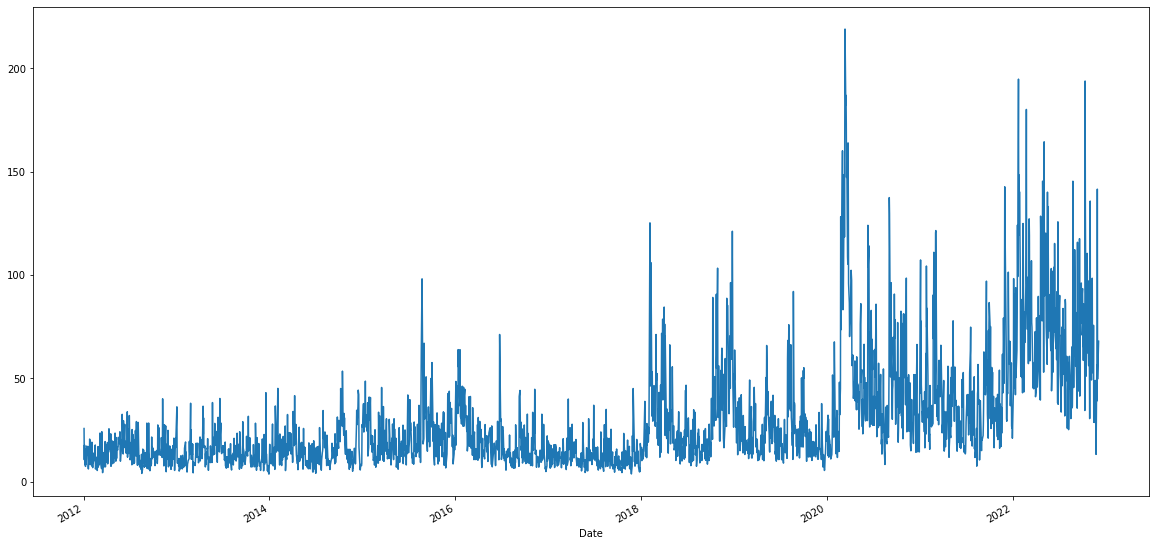

In [7]:
sample_data["Volatility"].plot()

<AxesSubplot:xlabel='Date'>

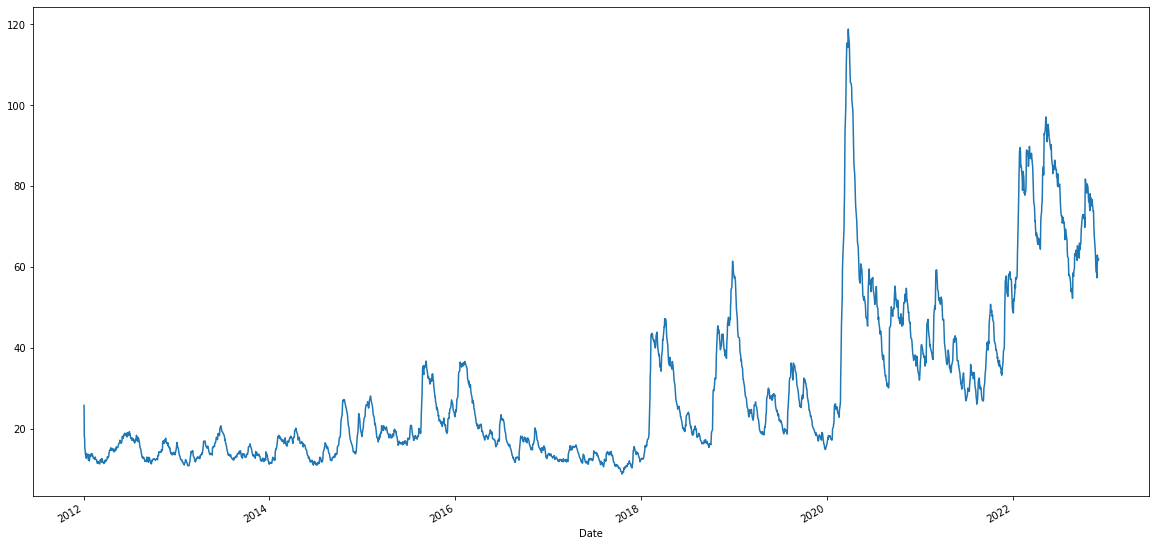

In [8]:
# We will scale each of these quantities by subtracting out the exponentially weighted
# moving average and then dividing by the exponentially weighted standard deviation.

# First we compute the exponentially weighted moving average of every column in the
# data frame, and plot the daily volatility’s exponentially weighted moving average

ewdf = sample_data.ewm(halflife = 10).mean()
ewdf.Volatility.plot()

<AxesSubplot:xlabel='Date'>

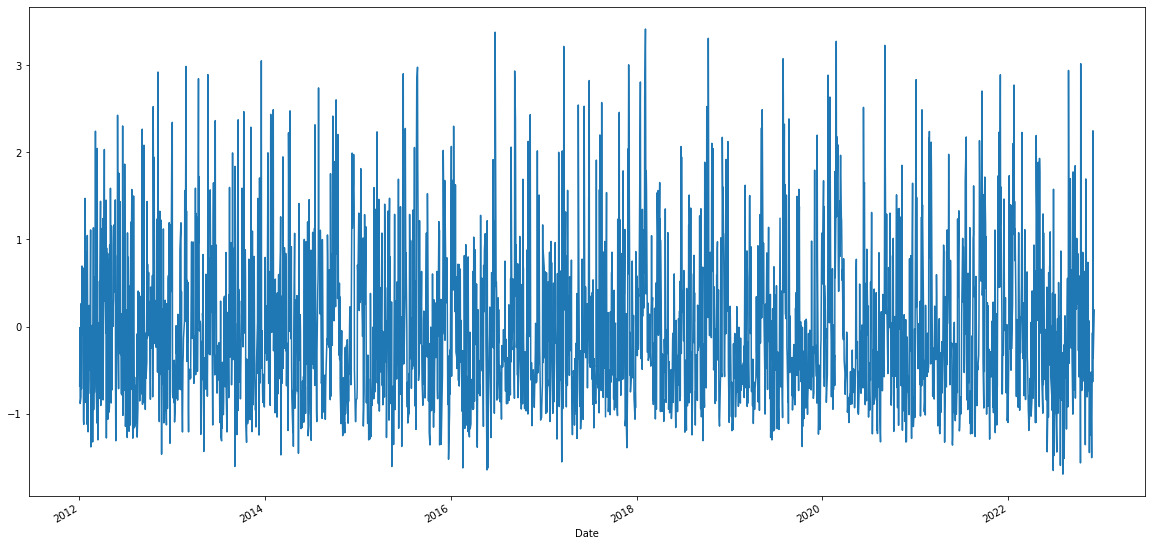

In [9]:
## compute exponentially weighted moving variance 
vewdf = sample_data.ewm(halflife = 10).var()

## scale by demeaning and normalizing
scaled = sample_data.Volatility - ewdf.Volatility
scaled = scaled / vewdf.Volatility**0.5
scaled.plot()

In [10]:
# We transform all three raw inputs of interest into a scaled version
sample_data['ScaledVolatility'] = ((sample_data.Volatility - ewdf.Volatility)/ vewdf.Volatility**0.5 )
sample_data['ScaledReturn'] = ((sample_data.Return - ewdf.Return)/ vewdf.Return**0.5 )
sample_data['ScaledVolume'] = ((sample_data.Volume - ewdf.Volume)/ vewdf.Volume**0.5 )

# Drop NA from exponential smoothing
sample_data = sample_data.dropna()

C:\Users\mathe\AppData\Local\Temp\ipykernel_40156\2981235131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['ScaledVolatility'] = ((sample_data.Volatility - ewdf.Volatility)/ vewdf.Volatility**0.5 )
C:\Users\mathe\AppData\Local\Temp\ipykernel_40156\2981235131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['ScaledReturn'] = ((sample_data.Return - ewdf.Return)/ vewdf.Return**0.5 )
C:\Users\mathe\AppData\Local\Temp\ipykernel_40156\2981235131.py:4: SettingWithCopyWarning: 
A va

In [11]:
#size = int(len(sample_data) * 0.8)
size = 2100
train, test = sample_data[0:size], sample_data[size:]

In [12]:
## build our pipeline variables off training data
## taking only values of interest from larger data frames
horizon = 10
X = train[:(size - horizon)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
Y = train[horizon:]["Return"].values

In [13]:
# put X into the format expected by a
# recurrent neural network architecture, namely TNC. 

# Add 1 more dimension to X
X = np.expand_dims(X, axis = 1)

X = np.split(X, X.shape[0]/10, axis = 0)
X = np.concatenate(X, axis = 1)
X.shape

(10, 209, 3)

In [14]:
# Building and training an RNN - LSTM
# architeture parameters 
NUM_HIDDEN = 4
NUM_LAYERS = 2

# data formatting parameters
BATCH_SIZE = 64
WINDOW_SIZE = 24

# training parameters
LEARNING_RATE = 1e-2
EPOCHS = 30

In [29]:
import math

# placeholders for inputs so the graph will know what shape to expect
tf.compat.v1.disable_eager_execution()

Xinp = tf.compat.v1.placeholder(dtype = tf.float32, shape = [WINDOW_SIZE, None, 3])
Yinp = tf.compat.v1.placeholder(dtype = tf.float32, shape = [None])

# build network, implement loss calculation and optimization steps
with tf.compat.v1.variable_scope("scope1", reuse=tf.compat.v1.AUTO_REUSE):
    cells = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=NUM_HIDDEN) for n in range(NUM_LAYERS)]
    stacked_rnn_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(cells)
    rnn_output, states = tf.compat.v1.nn.dynamic_rnn(stacked_rnn_cell, Xinp, dtype=tf.float32)
    W = tf.compat.v1.get_variable("W_fc", [NUM_HIDDEN, 1], initializer = tf.random_uniform_initializer(-.2, .2))

    ## notice we have no bias because we expect average zero return
    output = tf.compat.v1.squeeze(tf.matmul(rnn_output[-1, :, :], W))

    loss = tf.compat.v1.nn.l2_loss(output - Yinp)
    opt = tf.compat.v1.train.GradientDescentOptimizer(LEARNING_RATE)
    train_step = opt.minimize(loss)
    
#each data point should be in multiple time series depending on which offset we use
## for each epoch
y_hat_dict = {}
Y_dict = {}

in_sample_Y_dict = {}
in_sample_y_hat_dict = {}

for ep in range(EPOCHS):
    epoch_training_loss = 0.0
    for i in range(WINDOW_SIZE):
        X = train[:(7000 - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
        Y = train[WINDOW_SIZE:]["ScaledReturn"].values

        ## make it divisible by window size
        num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
        start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
        X = X[start_idx:]
        Y = Y[start_idx:] 

        X = X[i:-(WINDOW_SIZE-i)]
        Y = Y[i:-(WINDOW_SIZE-i)] 
 
        X = np.expand_dims(X, axis = 1)
        X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
        X = np.concatenate(X, axis = 1)
        Y = Y[::WINDOW_SIZE]
        
        ## TRAINING
        ## now batch it and run a sess
        for j in range(math.ceil(Y.shape[0] / BATCH_SIZE)):
            ll = BATCH_SIZE * j
            ul = BATCH_SIZE * (j + 1)

            if ul > X.shape[1]:
                ul = X.shape[1] - 1
                ll = X.shape[1]- BATCH_SIZE

            training_loss, _, y_hat = sess.run([loss, train_step, output],
                                               feed_dict = {Xinp: X[:, ll:ul, :],
                                                            Yinp: Y[ll:ul] })
            epoch_training_loss += training_loss 
 
            in_sample_Y_dict[ep] = Y[ll:ul]
            # notice this will only net us the last part of data trained on
            in_sample_y_hat_dict[ep] = y_hat

        # TESTING
        X = test_df[:(test_df.shape[0] - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
        Y = test_df[WINDOW_SIZE:]["ScaledReturn"].values
        num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
        start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
        # better to throw away beginning than end of training period when must delete
        X = X[start_idx:]
        Y = Y[start_idx:]
        X = np.expand_dims(X, axis = 1)
        X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
        X = np.concatenate(X, axis = 1)
        Y = Y[::WINDOW_SIZE]
        testing_loss, y_hat = sess.run([loss, output], feed_dict = { Xinp: X, Yinp: Y })
        # nb this is not great. we should really have a validation loss apart from testing

    print("Epoch: %d Training loss: %0.2f Testing loss %0.2f:" % (ep, epoch_training_loss, testing_loss))
    Y_dict[ep] = Y
    y_hat_dict[ep] = y_hat


C:\Users\mathe\AppData\Local\Temp\ipykernel_40156\1388413672.py:11: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cells = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=NUM_HIDDEN) for n in range(NUM_LAYERS)]


NameError: name 'sess' is not defined